# Regression modeling 

In [68]:
import warnings
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from yellowbrick.regressor import residuals_plot, ResidualsPlot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.svm import SVR
%matplotlib inline

# Minimal Features Dataset
    * ElasticNet
    * SVM
    * RandomForest
    * AdaBoost
    * Multilayer Perceptron

In [69]:
df_min = pd.read_csv("../data/dataset_minimal_features_for_modeling.csv")
print(df_min.shape)
df_min.head(n=2)


(83658, 40)


,School_Type_1.0,School_Type_4.0,Enrollment Teacher_Ratio2,Highest_Grade_Offered Rla_Pct_Part,Rla_Pct_Part,Rla_Pct_Part^2,Reduced_Price_Lunch Teacher_Ratio2,Teacher_Ratio2,Math_Pct_Part Rla_Pct_Part,Teacher_Ratio1,...,School_Level_4.0,Urban_Centric_Locale_12.0,School_Level_3.0,Virtual_0.0,School_Type_3.0,Grad_Rate,Ncessch,Year,Schnam,Stnam
0,1,0,221.627990,1170.0,97.5,9506.25,12.263999,0.438000,9506.25,0.064921,...,1,0,0,1,0,52.0,20000100208,2012,Bethel Regional High School,ALASKA
1,0,1,8.714286,1080.0,90.0,8100.00,0.000000,0.142857,8100.00,0.065574,...,0,0,1,1,0,10.0,20000100318,2012,Bethel Alternative Boarding School,ALASKA


In [70]:
# Split data into test & train
y = df_min.pop('Grad_Rate')
X = df_min
X.drop(["Ncessch", "Year", "Schnam", "Stnam"], axis=1, inplace=True)

Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)


In [71]:
X.dtypes

School_Type_1.0                         int64
School_Type_4.0                         int64
Enrollment Teacher_Ratio2             float64
Highest_Grade_Offered Rla_Pct_Part    float64
Rla_Pct_Part                          float64
Rla_Pct_Part^2                        float64
Reduced_Price_Lunch Teacher_Ratio2    float64
Teacher_Ratio2                        float64
Math_Pct_Part Rla_Pct_Part            float64
Teacher_Ratio1                        float64
Free_Lunch                            float64
Civilian_Labor_Force                  float64
All_Cohort                              int64
Enrollment                            float64
Free_Or_Reduced_Price_Lunch           float64
Teachers_Fte                          float64
Reduced_Price_Lunch                   float64
Math_Pct_Part                         float64
Unemployment_Rate                     float64
Title_I_Status_5.0                      int64
Charter_0.0                             int64
Urban_Centric_Locale_11.0         

In [84]:
def display_grid_results(results):
    print(f'Best parameters are: {results.best_params_}')
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,2)} + or -{round(std,2)} for the {params}')

## ElasticNet (Generalized Linear Model)

In [85]:
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                             variables=X.select_dtypes(include=np.number).columns.to_list())
min_max_scaler = SklearnTransformerWrapper(transformer=MinMaxScaler(),
                                             variables=X.select_dtypes(include=np.number).columns.to_list())
                                             
pipe_elastic = Pipeline(steps=[("scale", std_scaler),
                               ("general_linear",
                               ElasticNetCV(
                                l1_ratio=[0.1,0.4,0.7,1.0],
                                random_state=42,
                                max_iter=2000,
                                n_jobs=4,
                                cv=10))
                                ])

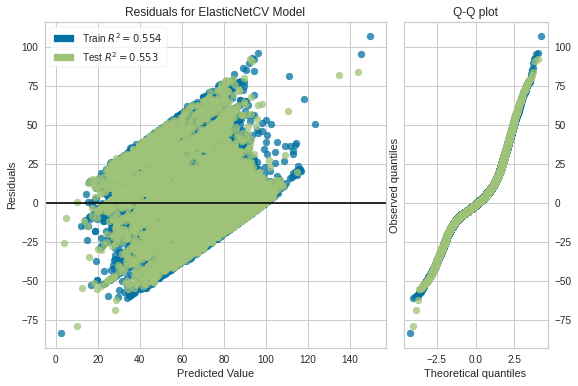

RMSE 12.994430473370663


AttributeError: 'ElasticNetCV' object has no attribute 'best_params_'

In [87]:
def make_residual_plot_and_print_rmse(Xtrain,ytrain,Xtest,ytest,pipe):
    grid_results = pipe.fit(Xtrain,ytrain)
    plt.rcParams['figure.figsize'] = (9,6)
    visualizer = ResidualsPlot(pipe, hist=False,qqplot=True)
    visualizer.fit(Xtrain, ytrain)
    visualizer.score(Xtest, ytest)
    visualizer.show()
    print("RMSE", mean_squared_error(ytest,visualizer.estimator.predict(Xtest),squared=False))
    return grid_results

elastic_grid_results = make_residual_plot_and_print_rmse(Xtrain,ytrain,Xtest,ytest,pipe_elastic)
display_grid_results()

# Support Vector Machine (SVR)

In [80]:
pipe_svm = Pipeline(steps=[("scale", std_scaler),
                               ("svr",
                               SVR())
                                ])

# warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
param_grid = {
    "svr__epsilon": [0.1,0.05,0.2],
    "svr__C": [1,2,3],
    "svr_kernel": ["poly","rbf"],
    "svr_degree": [3,4,5]}




results = {}
local_model_path = (
    "../../student_outcome_saved_models/model_minimal_features_svr_gridsearch1.pkl"
)
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe_svm,
        param_grid,
        n_jobs=4,
        verbose=3,
        cv=10,
        scoring="r2",
    )
    residuals_plot()
    joblib.dump(clf, local_model_path)



Fitting 10 folds for each of 54 candidates, totalling 540 fits


ValueError: Invalid parameter 'svr_degree' for estimator Pipeline(steps=[('scale',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['School_Type_1.0',
                                                      'School_Type_4.0',
                                                      'Enrollment '
                                                      'Teacher_Ratio2',
                                                      'Highest_Grade_Offered '
                                                      'Rla_Pct_Part',
                                                      'Rla_Pct_Part',
                                                      'Rla_Pct_Part^2',
                                                      'Reduced_Price_Lunch '
                                                      'Teacher_Ratio2',
                                                      'Teacher_Ratio2',
                                                      'Math_Pct_Part '
                                                      'Rla_Pct_Part',
                                                      'Teacher_Ratio1',
                                                      'Free_Lunch',
                                                      'Civilian...
                                                      'Free_Or_Reduced_Price_Lunch',
                                                      'Teachers_Fte',
                                                      'Reduced_Price_Lunch',
                                                      'Math_Pct_Part',
                                                      'Unemployment_Rate',
                                                      'Title_I_Status_5.0',
                                                      'Charter_0.0',
                                                      'Urban_Centric_Locale_11.0',
                                                      'Num_Grades',
                                                      'Lowest_Grade_Offered',
                                                      'Virtual_1.0',
                                                      'Metro_Or_Not_0.0',
                                                      'Rural_Urban_Continuum_Code_1.0',
                                                      'Title_I_Eligible_1.0',
                                                      'Title_I_Status_6.0',
                                                      'Urban_Influence_Code_1.0', ...])),
                ('svr', SVR())]). Valid parameters are: ['memory', 'steps', 'verbose'].